# Epipolar Geometry

برای به دست آوردن ماتریس فاندامنتال ابتدا روی عکس‌ها یک فیلتر گوسی برای حذف نویز اعمال می‌کنیم. سپس با استفاده از سیفت
تعدادی نقطه به دست می‌‌آوریم و آن‌ها را به صورت بروت فرس با هم مچ می‌کنیم. سپس با استفاده از $RANSAC$ ماتریس فاندامنتال را به دست
می‌آوریم.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img1 = plt.imread('./data/hw3/02.JPG')
img2 = plt.imread('./data/hw3/01.JPG')
img1 = cv.GaussianBlur(img1, (5, 5), 0)
img2 = cv.GaussianBlur(img2, (5, 5), 0)

sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
matcher = cv.BFMatcher()
matches_o = matcher.knnMatch(des1, des2, k=2)

matches = [m1 for m1, m2 in matches_o if m1.distance < 0.7 * m2.distance]
pts1 = np.int32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.int32([kp2[m.trainIdx].pt for m in matches])

F, mask = cv.findFundamentalMat(pts1, pts2,
                                cv.FM_RANSAC,
                                ransacReprojThreshold=3,
                                maxIters=500000,
                                confidence=0.995)

print('fundamental matrix:\n', F)

fundamental matrix:
 [[ 8.99469470e-10 -7.56005259e-08 -1.75702609e-04]
 [-6.79815313e-08  6.55825957e-09  1.69973807e-03]
 [-1.56862997e-04 -1.42504248e-03  1.00000000e+00]]


حال نقاط پرت و غیر پرت در روش رنسک را نمایش می‌دهیم:

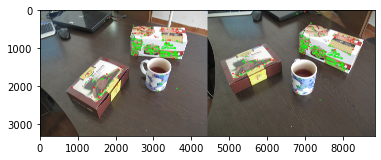

In [2]:
def draw_points(img, pts, color=(255, 0, 0)):
    img = img.copy()
    for i, pt in enumerate(pts):
        cv.circle(img, tuple(pt), 15, color, 5)
    return img


res05_1 = draw_points(draw_points(img1, pts1), pts1[mask.ravel() == 1], color=(0, 255, 0))
res05_2 = draw_points(draw_points(img2, pts2), pts2[mask.ravel() == 1], color=(0, 255, 0))
res05 = np.concatenate((res05_1, res05_2), axis=1)
plt.imshow(res05)
plt.show()

حال برای به دست آوردن اپیپول‌ها باید فضای پوچ راست و چپ $F$ را حساب کنیم تا به ترتیب، خطوط گذرنده از اپیپول‌های عکس اول و دوم در فضای تصویری به دست آید.
از آنجایی که صفحه دوربین در $z=1$ قرار دارد، پس نقطه برخورد آن خطوط با این صفحه را در نظر می‌گیریم که با تقسیم بردار بر درایه آخر آن به دست می‌آید.

برای به دست آوردن فضای پوچ، کافی‌ست تجزیه $SVD$ ماتریس $F$ را به دست آوریم؛ ستون آخر $V$ فضای پوچ راست ماتریس و سطر آخر $U$
فضای پوچ چپ ماتریس خواهد بود. زیرا بعد فضای پوچ ماتریس $F$ یک است.

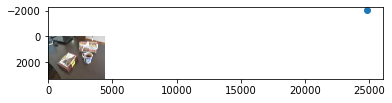

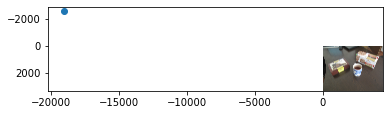

In [3]:
ep1 = np.linalg.svd(F)[2][2, :]
ep1 /= ep1[2]
ep2 = np.linalg.svd(F)[0][:, 2]
ep2 /= ep2[2]

# res06
plt.imshow(img1)
plt.scatter(ep1[0], ep1[1])
plt.show()

# res07
plt.imshow(img2)
plt.scatter(ep2[0], ep2[1])
plt.show()


با ضرب ماتریس فاندامنتال در هر نقطه، اپی‌لاین متناظر آن در تصویر دیگر به دست می‌آید که معادل صفحه گذرنده از آن خط در فضای تصویری‌ست.
به ازای ۱۰ تا از نقاط متناظر و غیر پرت، خطوط اپی‌لاین را رسم می‌کنیم که رسم نیز با داشتن معادله خط از ضرب ماتریس $F$ در
نقاط متناظر، ممکن است. البته برای انجا این ضرب لازم است تا با افزودن یک درایه یک به نقاط، آن‌ها را به فضای تصویری ببریم.

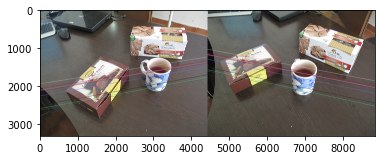

In [4]:
def calculate_epilines(pts, mat):
    pts = np.hstack((pts, np.ones((len(pts), 1)))).T
    lines = mat @ pts
    return lines.T


def get_color(i):
    return (i * 231) % 255, (i * 173) % 255, (i * 201) % 255


def draw_lines(img, lines):
    img = img.copy()
    for i, line in enumerate(lines):
        a, b, c = line
        x0, y0 = 0, int(-c / b)
        x1, y1 = img.shape[1], int((-c - a * img.shape[1]) / b)
        cv.line(img, (x0, y0), (x1, y1), get_color(i), 5)
    return img


pts1_s = pts1[mask.ravel() == 1][:10]
pts2_s = pts2[mask.ravel() == 1][:10]
img1_d = draw_lines(draw_points(img1, pts1_s), calculate_epilines(pts2_s, F.T))
img2_d = draw_lines(draw_points(img2, pts2_s), calculate_epilines(pts1_s, F))

res08 = np.concatenate((img1_d, img2_d), axis=1)

plt.imshow(res08)
plt.show()

